In [45]:
import numpy as np
import torch
import torchvision
from matplotlib import pyplot as plt
from torchvision import datasets, transforms, models
from tqdm import tqdm
import time

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])


cuda


In [47]:


trainset_vit = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform)

testset_vit = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform)

trainloader_vit = torch.utils.data.DataLoader(
    trainset_vit, batch_size=128, shuffle=True)

testloader_vit = torch.utils.data.DataLoader(
    testset_vit, batch_size=128, shuffle=False)


trainset_resnet = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform)

testset_resnet = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform)

trainloader_resnet = torch.utils.data.DataLoader(
    trainset_resnet, batch_size=128, shuffle=True)

testloader_resnet = torch.utils.data.DataLoader(
    testset_resnet, batch_size=128, shuffle=False)

classes = (
    'plane', 'car', 'bird', 'cat',
    'deer', 'dog', 'frog', 'horse',
    'ship', 'truck'
)

In [48]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(64*8*8, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)


In [49]:
from torchvision.models import vit_b_16

def get_vit_model(num_classes=10, freeze_backbone=True):

    model_vit = vit_b_16(weights="IMAGENET1K_V1")
    model_vit.heads.head = nn.Linear(
        model_vit.heads.head.in_features, num_classes)

    if freeze_backbone:
        for param in model_vit.parameters():
            param.requires_grad = False
        for param in model_vit.heads.head.parameters():
            param.requires_grad = True
    return model_vit

In [50]:
from torchvision.models import resnet18

def get_resnet_model(num_classes=10, freeze_backbone=True):

    model = resnet18(weights="IMAGENET1K_V1")

    # Αλλάζουμε το τελευταίο layer
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    if freeze_backbone:
        for param in model.parameters():
            param.requires_grad = False

        for param in model.fc.parameters():
            param.requires_grad = True

    return model

In [51]:
def train_one_epoch(model, loader, optimizer, criterion, device, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    pbar = tqdm(loader, desc=f"Epoch {epoch+1}", leave=False)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        acc = 100 * correct / total

        pbar.set_postfix(
            loss=loss.item(),
            acc=f"{acc:.2f}%"
        )

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total

    return epoch_loss, epoch_acc

In [52]:
def train_model(model, train_loader, test_loader, epochs, lr, name, device):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()

    if hasattr(model, "heads"): # ViT
        optimizer = torch.optim.Adam(model.heads.head.parameters(), lr=lr)
    elif hasattr(model, "fc"):   # ResNet
        optimizer = torch.optim.Adam(model.fc.parameters(), lr=lr)
    else:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    history = {"train_loss": [],
               "train_acc": [],
               "val_loss": [],
               "val_acc": [],
               "epoch_time": []
    }

    total_start_time = time.time()

    for epoch in range(epochs):
        epoch_start_time = time.time()

        train_loss, train_acc = train_one_epoch(
            model, train_loader, optimizer, criterion, device, epoch
        )
        val_loss, val_acc = evaluate(
            model, test_loader, criterion ,device
        )
        epoch_end = time.time()
        epoch_time = epoch_end - epoch_start_time
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["epoch_time"].append(epoch_time)

        print(
            f"Epoch {epoch+1}/{epochs} | "
            f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%"
            f"⏱ Time: {epoch_time:.1f}s"
        )
    total_time = time.time() - total_start_time
    print(f" Total training time for {name}: {total_time/60:.2f} minutes")

    return history

In [53]:
def evaluate(model, loader, criterion, device, epoch=None, epochs=None):
    model.eval()
    running_loss = 0.0
    correct, total = 0, 0
    desc = "Validation" if epoch is None else f"Epoch {epoch+1}/{epochs} [Val]"
    val_bar = tqdm(loader, desc=desc, leave=False)
    with torch.no_grad():
        for images, labels in val_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            val_bar.set_postfix(
                loss=loss.item(),
                accuracy= 100 * correct / total
            )
    val_loss = running_loss / len(loader)
    val_acc = 100 * correct / total

    return val_loss, val_acc

In [54]:
def plot_history(histories):
    # Loss
    plt.figure(figsize=(12,5))
    for name, history in histories.items():
        plt.plot(history["train_loss"], label=f"{name} Train Loss")
        plt.plot(history["val_loss"], linestyle="--", label=f"{name} Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss Curves")
    plt.show()

    # Accuracy
    plt.figure(figsize=(12,5))
    for name, history in histories.items():
        plt.plot(history["train_acc"], label=f"{name} Train Acc")
        plt.plot(history["val_acc"], linestyle="--", label=f"{name} Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.title("Accuracy Curves")
    plt.show()


In [55]:
def plot_times_and_efficiency(histories):
    # --- Plot epoch times ---
    plt.figure(figsize=(12,5))
    for name, history in histories.items():
        plt.plot(history["epoch_time"], marker="o", label=name)
    plt.xlabel("Epoch")
    plt.ylabel("Seconds")
    plt.title("Training Time per Epoch")
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- Compute efficiency ---
    names = []
    efficiencies = []

    for name, history in histories.items():
        total_time = sum(history["epoch_time"])
        final_acc = history["val_acc"][-1]
        sec_per_acc = total_time / final_acc

        names.append(name)
        efficiencies.append(sec_per_acc)

    # --- Bar plot efficiency ---
    plt.figure(figsize=(10,5))
    plt.bar(names, efficiencies)
    plt.ylabel("Seconds per 1% Accuracy")
    plt.title("Efficiency: Time Cost per Accuracy Unit")
    plt.xticks(rotation=30)
    plt.grid(True, axis="y")
    plt.show()

    # --- Print numeric table ---
    print("\n⏱ Efficiency Table:")
    for name, eff in zip(names, efficiencies):
        print(f"{name:15s} : {eff:.2f} seconds per 1% accuracy")


In [56]:
import seaborn
from sklearn.metrics import confusion_matrix


def compute_confusion_matrix(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    cm = confusion_matrix(all_labels, all_preds)
    return cm

def plot_confusion_matrix(cm, classes, title):
    plt.figure(figsize=(10,8))
    seaborn.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=classes,
        yticklabels=classes
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()


In [57]:
def train_with_time_budget(model, train_loader, test_loader,
                           max_seconds, lr, device, name):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()

    if hasattr(model, "heads"):
        optimizer = torch.optim.Adam(model.heads.head.parameters(), lr=lr)
    else:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    history = {
        "time": [],
        "train_acc": [],
        "val_acc": []
    }

    start_time = time.time()
    epoch = 0

    while True:
        epoch_start = time.time()

        model.train()
        correct, total = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

        train_acc = 100 * correct / total

        val_loss, val_acc = evaluate(model, test_loader, criterion, device)

        elapsed = time.time() - start_time

        history["time"].append(elapsed)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(
            f"[{name}] Epoch {epoch+1} | "
            f"Time: {elapsed:.1f}s | "
            f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%"
        )

        epoch += 1

        if elapsed >= max_seconds:
            print(f"⏱ Time budget reached for {name}")
            break

    return history

def plot_accuracy_vs_time(histories):
    plt.figure(figsize=(10,6))

    for name, history in histories.items():
        plt.plot(
            history["time"],
            history["val_acc"],
            marker="o",
            label=name
        )

    plt.xlabel("Time (seconds)")
    plt.ylabel("Validation Accuracy (%)")
    plt.title("Accuracy vs Training Time")
    plt.legend()
    plt.grid(True)
    plt.show()

In [58]:
def show_predictions(model, loader, classes, device, num_images=8):
    model.eval()
    images_shown = 0

    plt.figure(figsize=(16,8))

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for i in range(images.size(0)):
                if images_shown >= num_images:
                    plt.show()
                    return

                img = images[i].cpu()
                img = img * 0.5 + 0.5  # unnormalize

                plt.subplot(2, num_images//2, images_shown+1)
                plt.imshow(np.transpose(img.numpy(), (1,2,0)))
                plt.axis("off")

                true_label = classes[labels[i]]
                pred_label = classes[preds[i]]

                color = "green" if true_label == pred_label else "red"
                plt.title(
                    f"T: {true_label}\nP: {pred_label}",
                    color=color
                )

                images_shown += 1


In [59]:
results ={}

# 1) ResNet, 3 epochs, lr=1e-3
resnet_3ep = get_resnet_model()
history_resnet3 = train_model(
    resnet_3ep,
    trainloader_resnet,
    testloader_resnet,
    epochs=3,
    lr=1e-3,
    name="ResNet 3ep",
    device=device
)
results["ResNet 3ep"] = history_resnet3

Epoch 1/3 | Train Loss: 0.8966, Train Acc: 71.79% | Val Loss: 0.6475, Val Acc: 78.53%⏱ Time: 145.6s


Epoch 2/3 | Train Loss: 0.6209, Train Acc: 78.96% | Val Loss: 0.6059, Val Acc: 79.09%⏱ Time: 144.7s


Epoch 3/3 | Train Loss: 0.5833, Train Acc: 80.12% | Val Loss: 0.5848, Val Acc: 80.16%⏱ Time: 138.8s
 Total training time for ResNet 3ep: 7.15 minutes


In [60]:
# 2) ResNet, 5 epochs, lr=1e-3
resnet_5ep = get_resnet_model()
history_resnet5 = train_model(
    resnet_5ep,
    trainloader_resnet,
    testloader_resnet,
    epochs=5,
    lr=1e-3,
    name="ResNet 5ep",
    device=device
)
results["ResNet 5ep"] = history_resnet5

Epoch 1/5 | Train Loss: 0.8917, Train Acc: 71.97% | Val Loss: 0.6564, Val Acc: 78.08%⏱ Time: 141.6s


Epoch 2/5 | Train Loss: 0.6223, Train Acc: 78.92% | Val Loss: 0.6025, Val Acc: 79.60%⏱ Time: 138.6s


Epoch 3/5 | Train Loss: 0.5814, Train Acc: 79.95% | Val Loss: 0.6038, Val Acc: 79.23%⏱ Time: 138.7s


Epoch 4/5 | Train Loss: 0.5650, Train Acc: 80.51% | Val Loss: 0.5791, Val Acc: 79.86%⏱ Time: 132.2s


Epoch 5/5 | Train Loss: 0.5536, Train Acc: 80.99% | Val Loss: 0.5769, Val Acc: 80.24%⏱ Time: 138.9s
 Total training time for ResNet 5ep: 11.50 minutes


In [61]:
# 3) ViT, 3 epochs, lr=1e-3
vit_model_3ep = get_vit_model()
history_vit = train_model(vit_model_3ep, trainloader_vit, testloader_vit,
                          epochs=3, lr=1e-3, name="ViT 3ep", device=device)
results["ViT 3ep"] = history_vit

Epoch 1/3 | Train Loss: 0.3073, Train Acc: 91.31% | Val Loss: 0.1953, Val Acc: 93.76%⏱ Time: 1217.2s


Epoch 2/3 | Train Loss: 0.1760, Train Acc: 94.23% | Val Loss: 0.1741, Val Acc: 94.28%⏱ Time: 1230.3s


Epoch 3/3 | Train Loss: 0.1560, Train Acc: 94.82% | Val Loss: 0.1662, Val Acc: 94.51%⏱ Time: 1216.9s
 Total training time for ViT 3ep: 61.07 minutes


In [62]:
# 4) ViT, 5 epochs, lr=1e-3
vit_model_5ep = get_vit_model()
history_vit5 = train_model(vit_model_5ep, trainloader_vit, testloader_vit,
                           epochs=5, lr=1e-3, name="ViT 5ep", device=device)
results["ViT 5ep"] = history_vit5

Epoch 1/5 | Train Loss: 0.3015, Train Acc: 91.45% | Val Loss: 0.1957, Val Acc: 93.58%⏱ Time: 1259.9s


Epoch 2/5 | Train Loss: 0.1756, Train Acc: 94.34% | Val Loss: 0.1737, Val Acc: 94.19%⏱ Time: 1236.6s


Epoch 3/5 | Train Loss: 0.1555, Train Acc: 94.86% | Val Loss: 0.1634, Val Acc: 94.41%⏱ Time: 1219.4s


Epoch 4/5 | Train Loss: 0.1443, Train Acc: 95.22% | Val Loss: 0.1613, Val Acc: 94.56%⏱ Time: 1222.2s


Epoch 5/5 | Train Loss: 0.1362, Train Acc: 95.54% | Val Loss: 0.1579, Val Acc: 94.66%⏱ Time: 1197.2s
 Total training time for ViT 5ep: 102.26 minutes


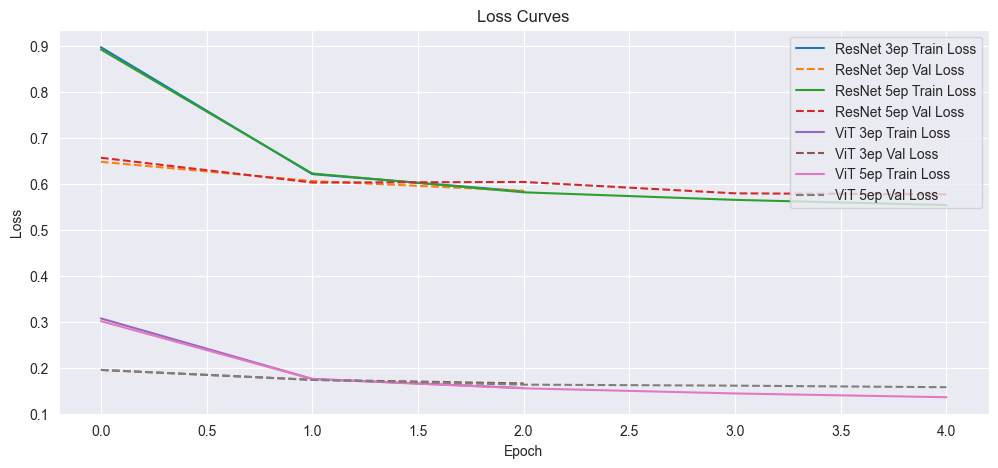

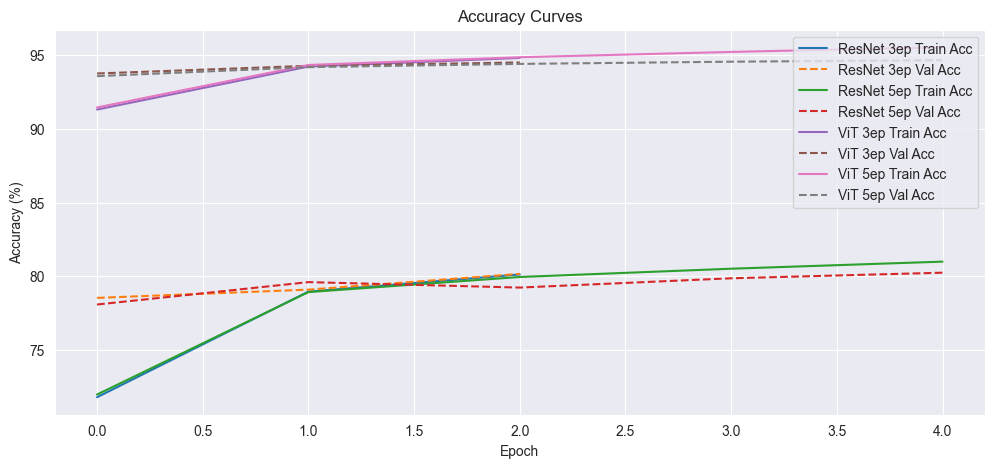

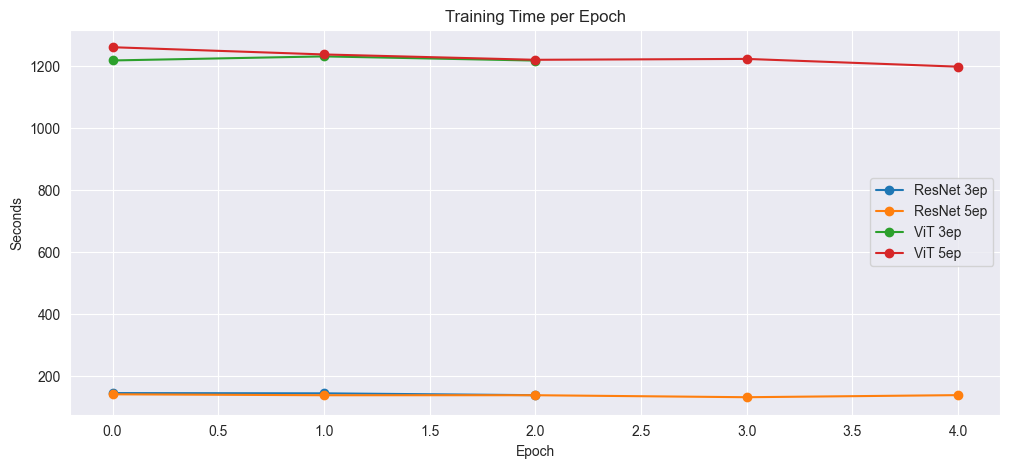

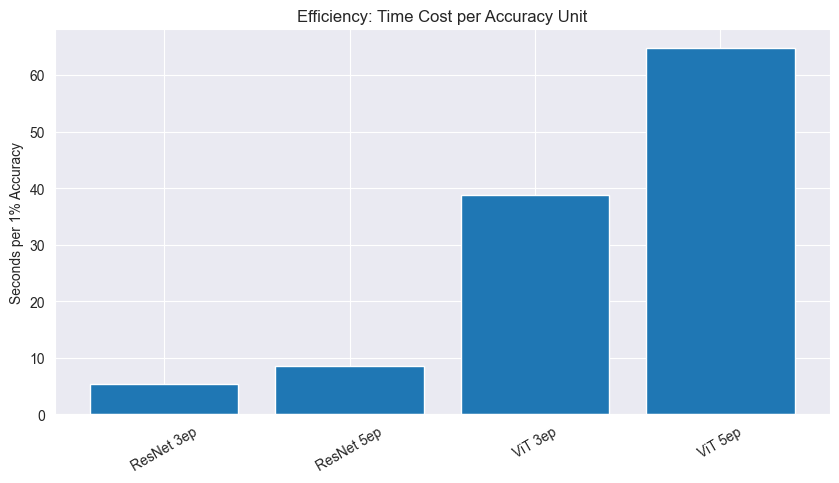


⏱ Efficiency Table:
ResNet 3ep      : 5.35 seconds per 1% accuracy
ResNet 5ep      : 8.60 seconds per 1% accuracy
ViT 3ep         : 38.77 seconds per 1% accuracy
ViT 5ep         : 64.81 seconds per 1% accuracy


In [63]:

plot_history(results)
plot_times_and_efficiency(results)


=== Confusion Matrix for CNN 3ep ===


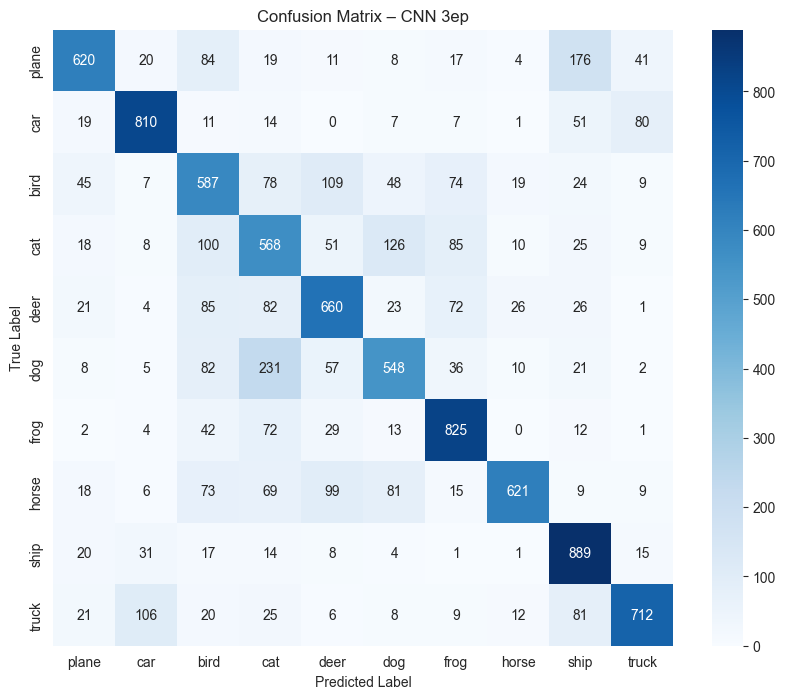


=== Confusion Matrix for CNN 5ep ===


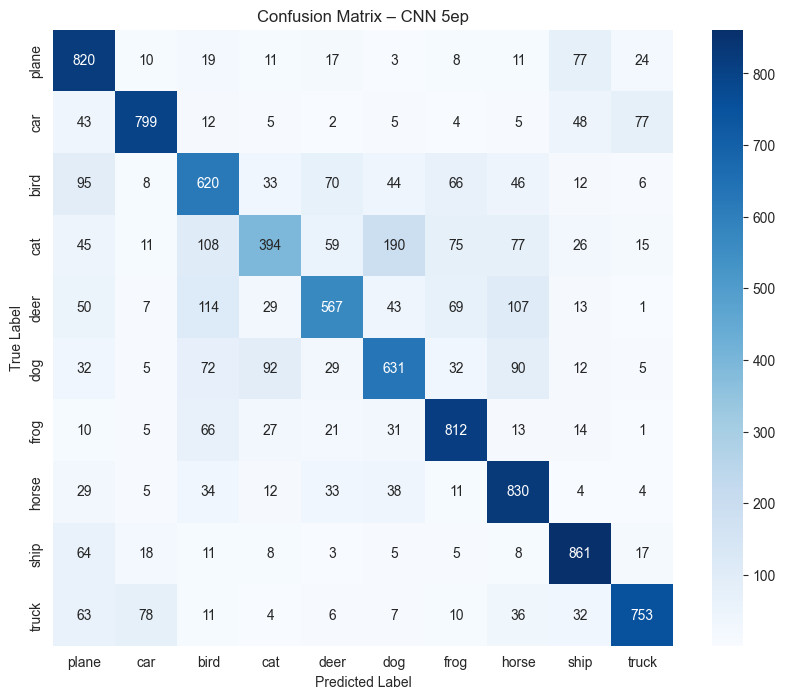


=== Confusion Matrix for ViT 3ep ===


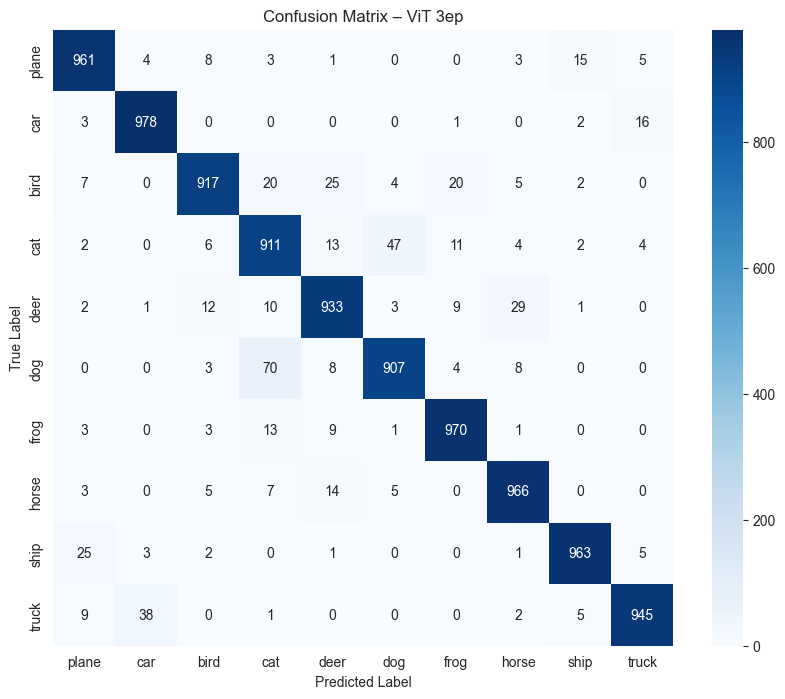


=== Confusion Matrix for ViT 5ep ===


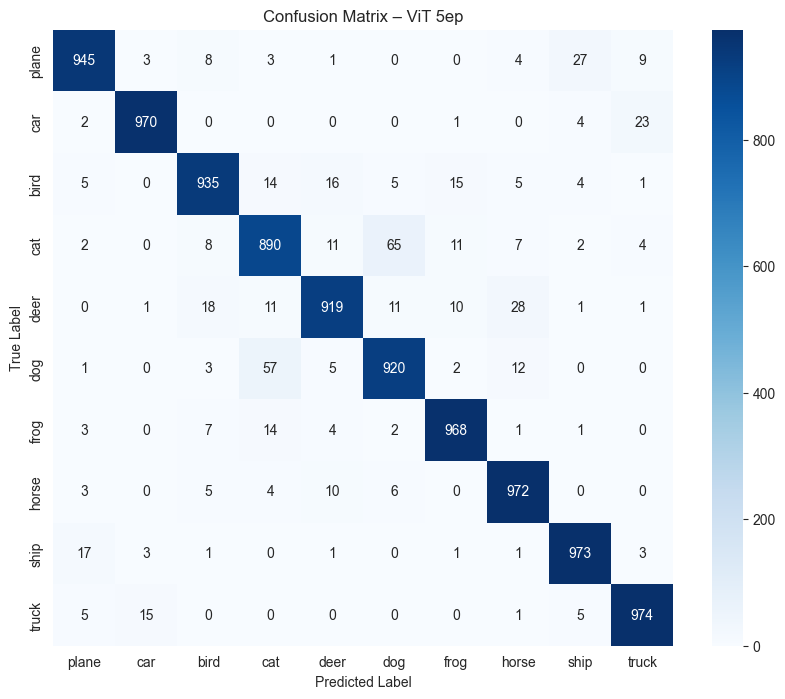

In [64]:
# Λίστα με τα μοντέλα και τους αντίστοιχους loaders
models_and_loaders = {
    "CNN 3ep": (resnet_3ep, testloader_resnet),
    "CNN 5ep": (resnet_5ep, testloader_resnet),
    "ViT 3ep": (vit_model_3ep, testloader_vit),
    "ViT 5ep": (vit_model_5ep, testloader_vit)
}

# Υπολογισμός και plot των confusion matrices
for name, (model, loader) in models_and_loaders.items():
    print(f"\n=== Confusion Matrix for {name} ===")
    cm = compute_confusion_matrix(model, loader, device)
    plot_confusion_matrix(cm, classes, f"Confusion Matrix – {name}")




=== Sample Predictions for CNN 3ep ===


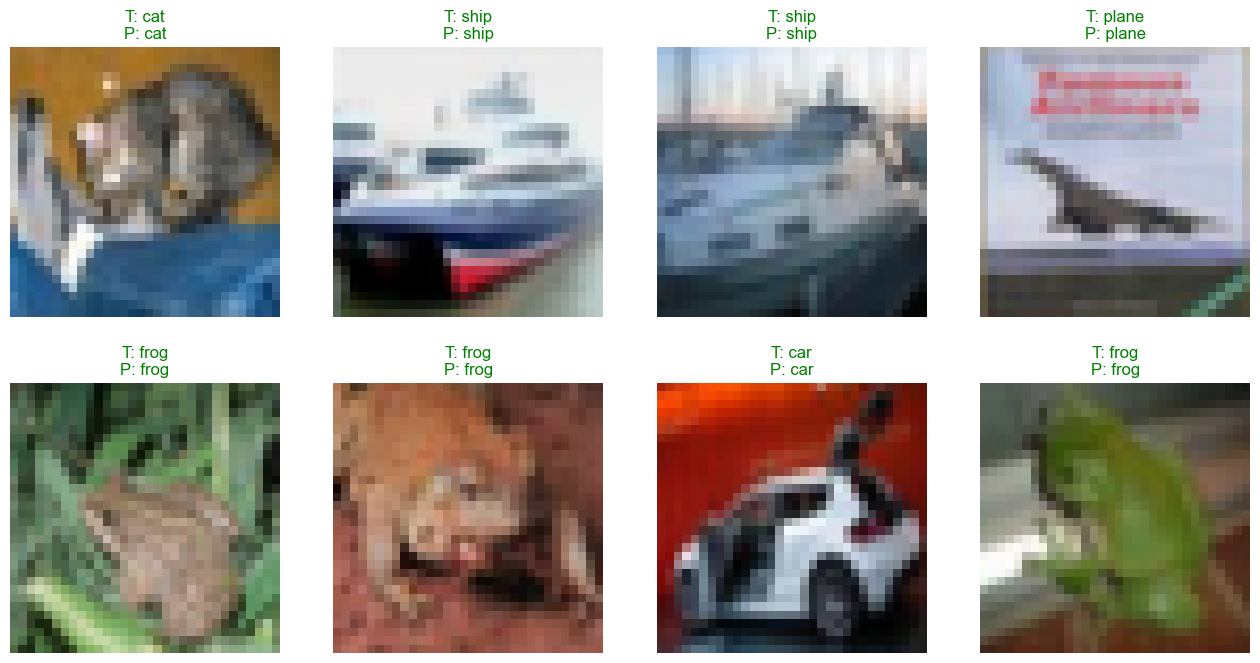


=== Sample Predictions for CNN 5ep ===


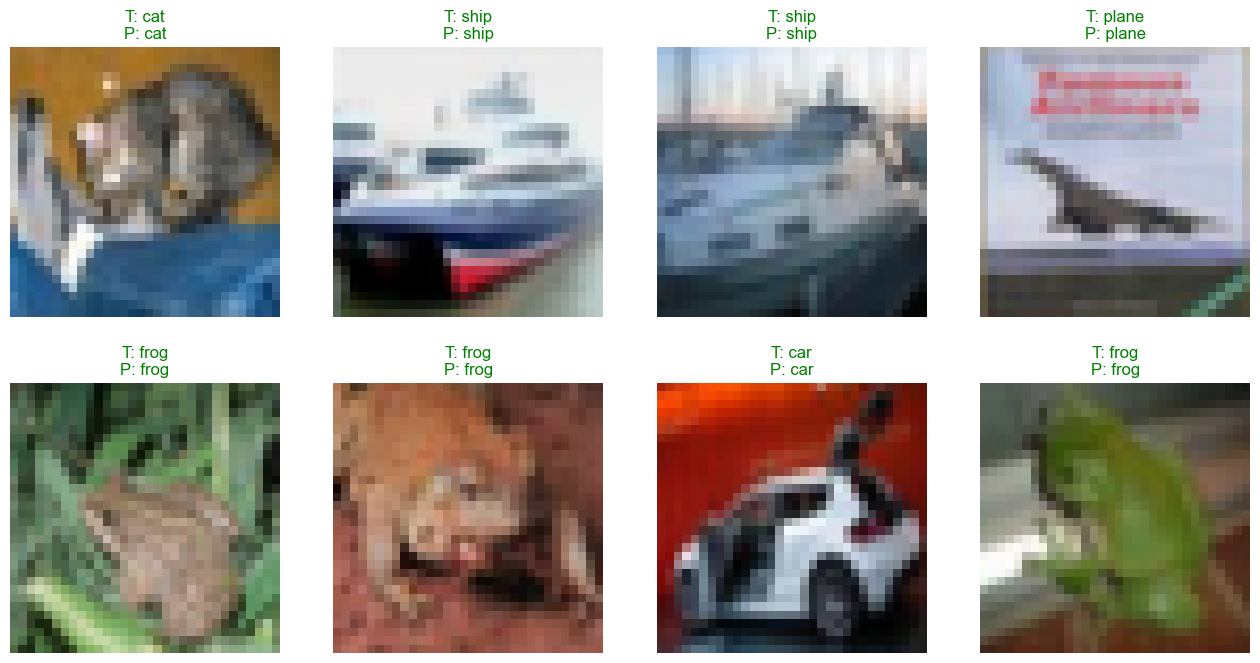


=== Sample Predictions for ViT 3ep ===


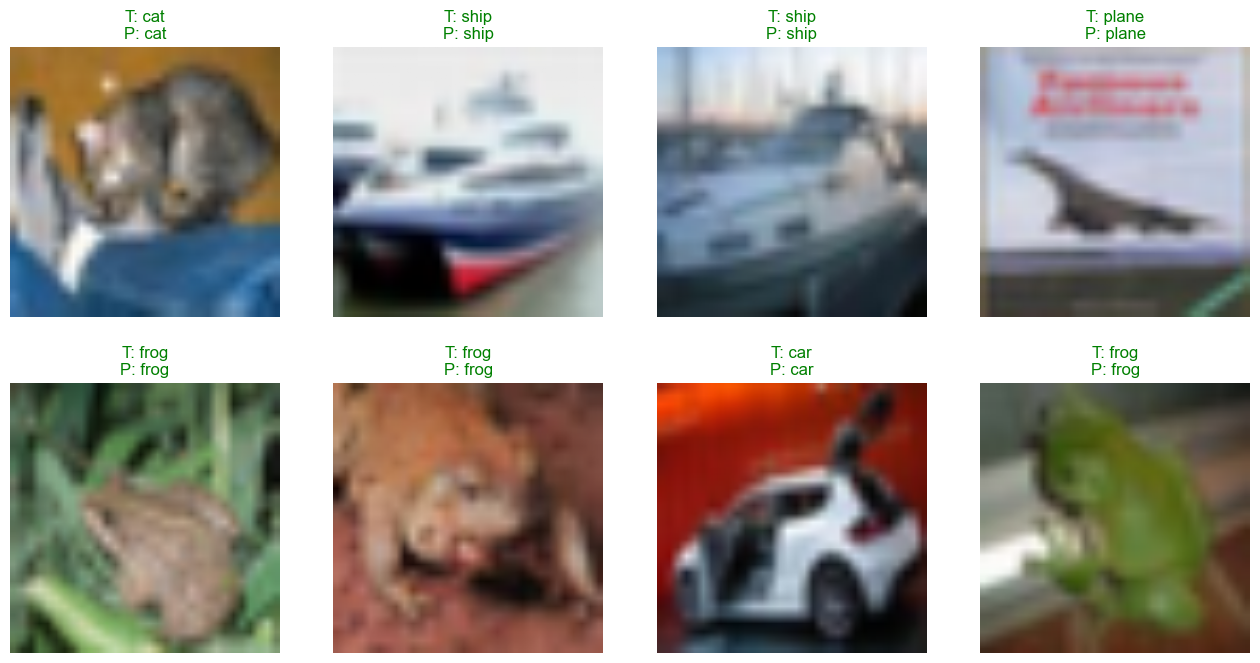


=== Sample Predictions for ViT 5ep ===


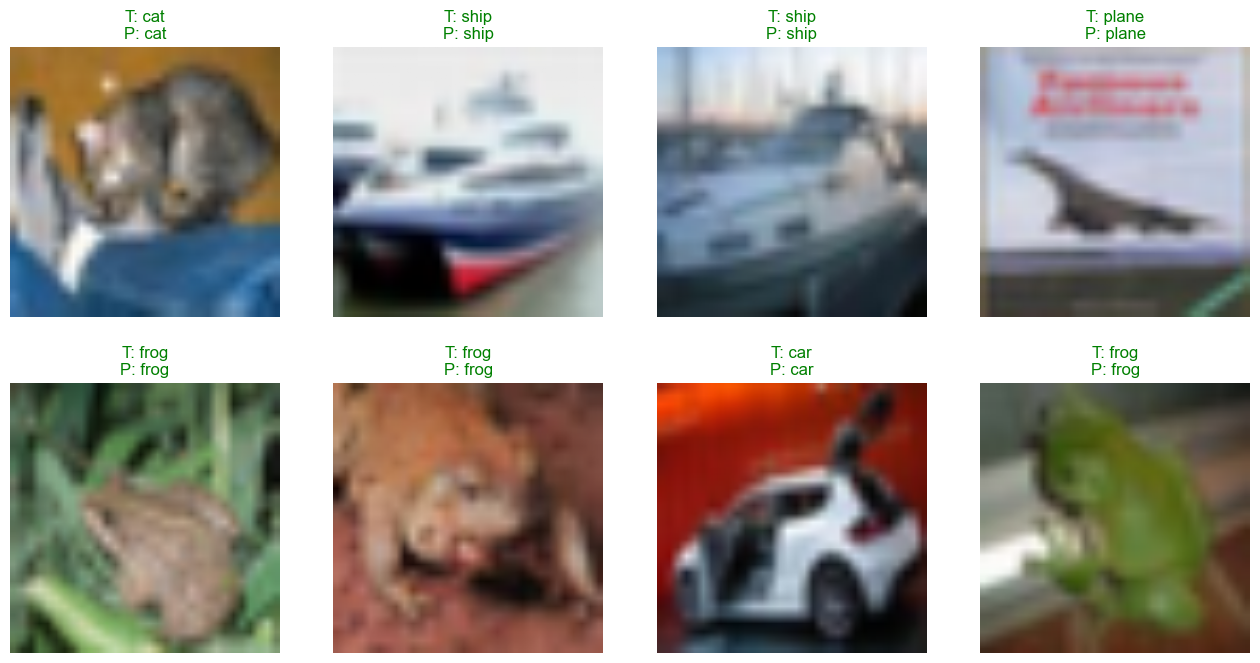

In [65]:
for name, (model, loader) in models_and_loaders.items():
    print(f"\n=== Sample Predictions for {name} ===")
    show_predictions(model, loader, classes, device, num_images=8)


In [66]:
# TIME_BUDGET = 3180  # seconds (~53 minutes)
#
# cnn_model = SimpleCNN()
# cnn_time_history = train_with_time_budget(
#     model=cnn_model,
#     train_loader=trainloader_cnn,
#     test_loader=testloader_cnn,
#     max_seconds=TIME_BUDGET,
#     lr=1e-3,
#     device=device,
#     name="CNN (time-budget)"
# )



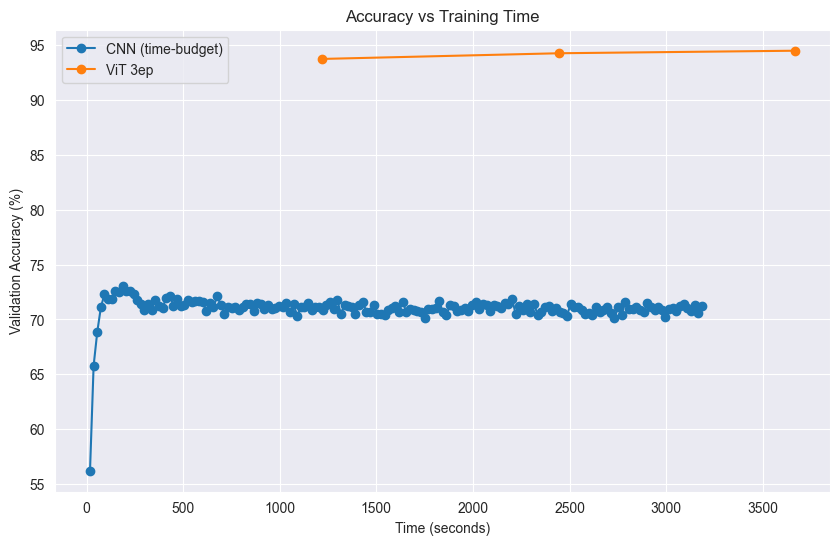

In [67]:
history_vit_time = {
    "time": np.cumsum(history_vit["epoch_time"]).tolist(),
    "val_acc": history_vit["val_acc"]
}


plot_accuracy_vs_time({
    "CNN (time-budget)": cnn_time_history,
    "ViT 3ep": history_vit_time
})

In [69]:
# ResNet
results = {}


resnet_model = get_resnet_model()
history_resnet = train_model(
    resnet_model,
    trainloader_resnet,
    testloader_resnet,
    epochs=3,
    lr=3e-4,
    name="ResNet 5ep (lr=1e-4)",
    device=device
)

# ViT
vit_model = get_vit_model()
history_vit = train_model(
    vit_model,
    trainloader_vit,
    testloader_vit,
    epochs=3,
    lr=3e-4,
    name="ViT 5ep (lr=1e-4)",
    device=device
)


Epoch 1/3 | Train Loss: 1.2407, Train Acc: 63.96% | Val Loss: 0.8471, Val Acc: 75.17%⏱ Time: 136.8s


Epoch 2/3 | Train Loss: 0.7652, Train Acc: 76.29% | Val Loss: 0.7002, Val Acc: 77.55%⏱ Time: 146.7s


Epoch 3/3 | Train Loss: 0.6752, Train Acc: 78.22% | Val Loss: 0.6503, Val Acc: 78.56%⏱ Time: 146.8s
 Total training time for ResNet 5ep (lr=1e-4): 7.17 minutes


Epoch 1/3 | Train Loss: 0.5406, Train Acc: 87.44% | Val Loss: 0.2631, Val Acc: 92.74%⏱ Time: 1259.9s


Epoch 2/3 | Train Loss: 0.2325, Train Acc: 92.93% | Val Loss: 0.2151, Val Acc: 93.38%⏱ Time: 1254.9s


Epoch 3/3 | Train Loss: 0.1995, Train Acc: 93.66% | Val Loss: 0.1957, Val Acc: 93.69%⏱ Time: 1252.8s
 Total training time for ViT 5ep (lr=1e-4): 62.79 minutes


In [72]:
results["ResNet LR=3e-4"] = history_resnet
results["ViT LR=3e-4 "] = history_vit

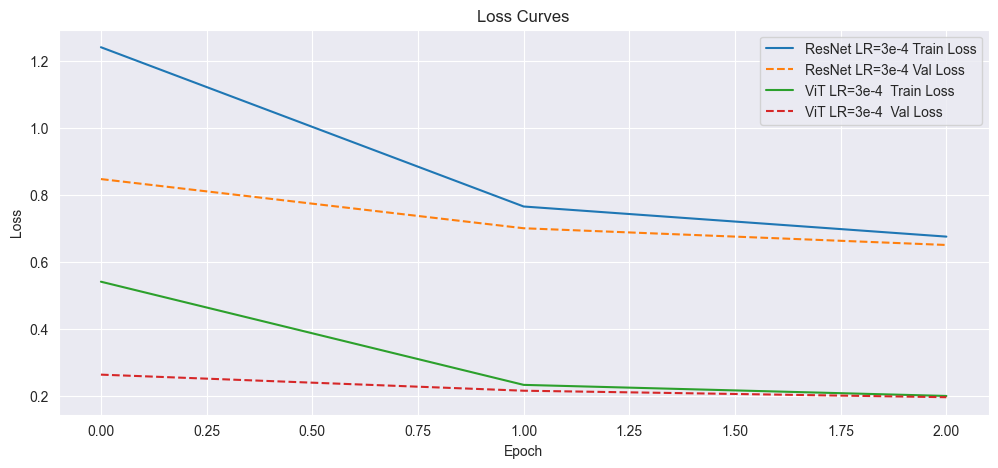

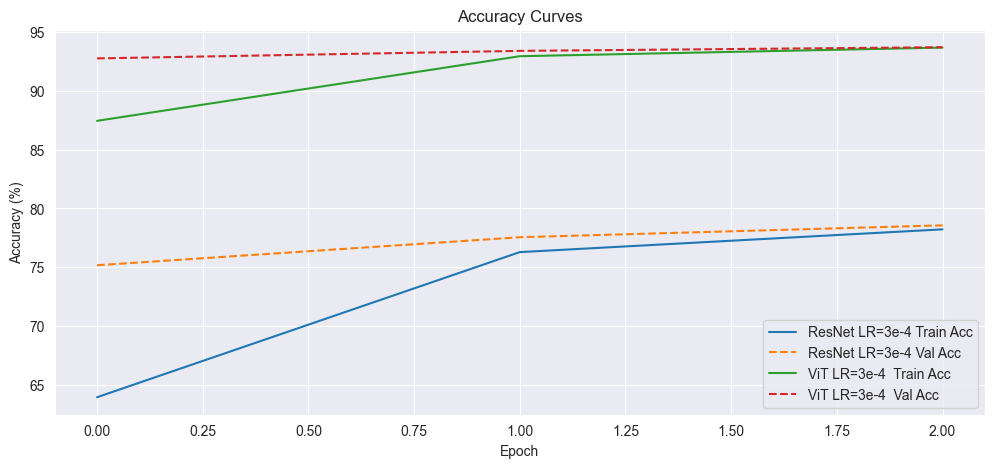

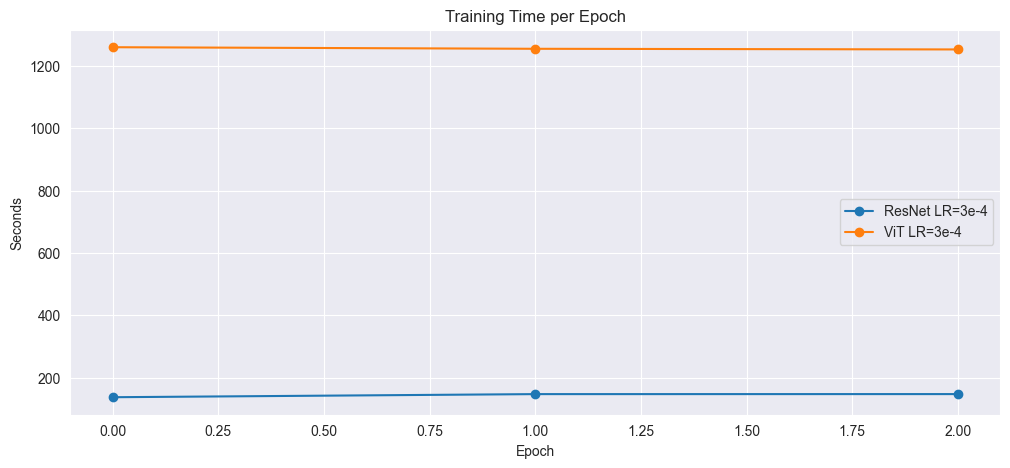

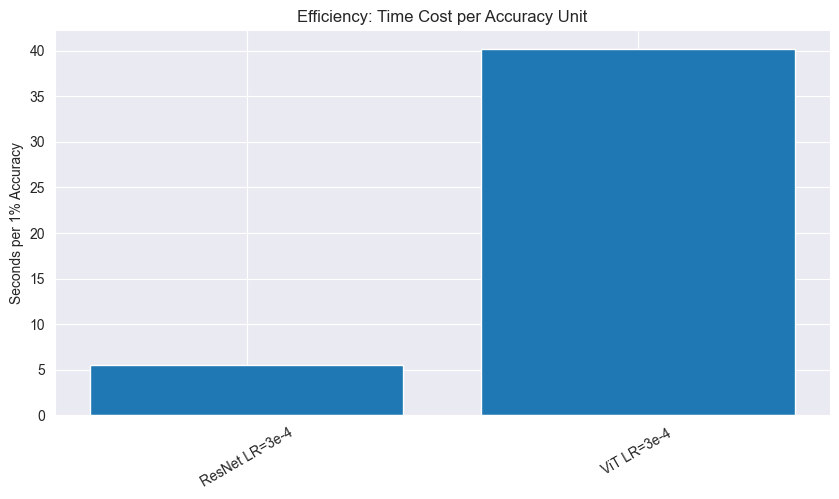


⏱ Efficiency Table:
ResNet LR=3e-4  : 5.48 seconds per 1% accuracy
ViT LR=3e-4     : 40.21 seconds per 1% accuracy


In [73]:
plot_history(results)
plot_times_and_efficiency(results)

In [74]:
models_and_loaders = {
    "ResNet lr=1e-4": (resnet_model, testloader_resnet),
    "ViT lr=1e-4": (vit_model, testloader_vit)
}